In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the saved model
model_path = '/mnt/d/projects/PlantVillage/Trained_model/89.30 - efficientnet_model.pth'
model = models.efficientnet_b0(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 64),
    nn.ReLU(),
    nn.Linear(64, 39),
    nn.Softmax(dim=1)
)
model.load_state_dict(torch.load(model_path))
model.eval()

In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Grad-CAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
        
    def save_activation(self, module, input, output):
        self.activations = output
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
        
    def generate_cam(self, input_image, target_class=None):
        if target_class is None:
            target_class = torch.argmax(self.model(input_image))
        
        self.model.zero_grad()
        output = self.model(input_image)
        loss = output[0, target_class]
        loss.backward()
        
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))
        
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]
        
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_image.shape[2:])
        cam -= np.min(cam)
        cam /= np.max(cam)
        return cam

In [ ]:
# Function to preprocess the image
def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert the image from NumPy array to PIL Image
    img_pil = Image.fromarray(img)
    
    img_tensor = preprocess(img_pil).unsqueeze(0)
    return img_tensor.to(device), img

/home/typpo/anaconda3/envs/vtorch/lib/python3.12/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


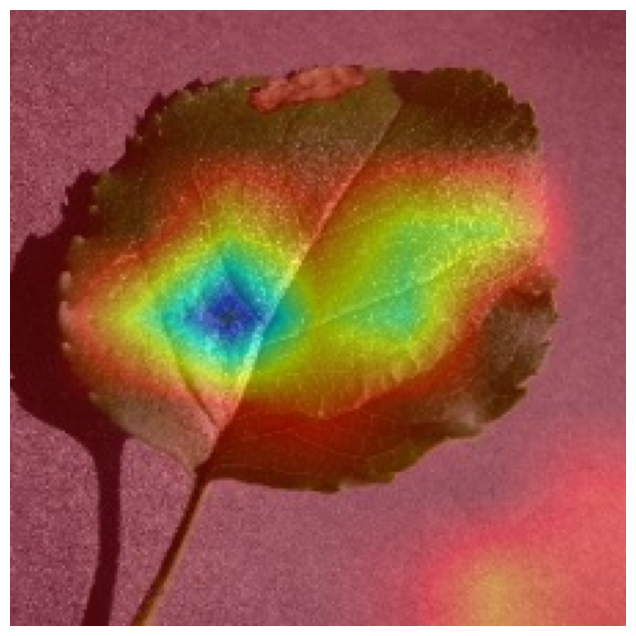

In [ ]:
# Load an example image from your dataset
img_path = '/mnt/d/projects/PlantVillage/hmm.JPG'  # Replace with your image path
input_image, original_image = preprocess_image(img_path)

# Initialize GradCAM and generate the CAM
gradcam = GradCAM(model, model.features[6])  # Layer depends on your model architecture
cam = gradcam.generate_cam(input_image)

# Superimpose the CAM on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
cam_image = heatmap + np.float32(cv2.resize(original_image, (224, 224)) / 255)
cam_image = cam_image / np.max(cam_image)

# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(cam_image)
plt.axis('off')
plt.show()